# INSTALL REQUIREMENTS

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 14.3 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 85.4 MB/s 
     |████████████████████████████████| 596 kB 86.4 MB/s 
     |████████████████████████████████| 895 kB 81.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# for XLNet

!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 16.6 MB/s 


In [3]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 14.9 MB/s 
     |████████████████████████████████| 144 kB 86.2 MB/s 
     |████████████████████████████████| 181 kB 92.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=68245a8e08f3ca99aa0721cbd620e4d997a5671c88faa49fb39a3d97d2aaae82
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# GOOGLE MOUNT

In [4]:
from google.colab import drive
drive.mount('/content/drive')
PATH = './drive/MyDrive/datasets/'

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/groom_project1/

/content/drive/MyDrive/groom_project1


In [6]:
%pwd

'/content/drive/MyDrive/groom_project1'

# IMPORT REQUIREMENTS

In [7]:
import os
import sys
import random
import pickle

import numpy as np
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence

from transformers import (
    AdamW
)

import wandb

# import costumized modules
from compute import compute_acc
from visualize_score import plot_graph
from dump_datasets import mk_dataset, mk_dataset_xlnet
from dump_models import load_model, load_model_xlnet
from evaluate import test_model
from data_processing import regular

#CREATE FOLDER

In [8]:
# create required folders if not exists

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
 
createFolder('./best_models')
createFolder('./dump_datasets')
createFolder('./dump_models_tokenizer')
createFolder('./scores')
createFolder('./submissions')

# FIX SEED

In [9]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

# MODEL

In [10]:
# test various models

MODEL_NAME = 'bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME = 'xlnet-base-cased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert str(device) == 'cuda'


# by using pickle, load dump file if exist, else make dump file and load
# load for bert(uncased) or xlnet model(cased)

try:
    with open('./dump_models_tokenizer/' + MODEL_NAME + '.p', 'rb') as f:
        model = pickle.load(f)
        tokenizer = pickle.load(f)
        print('./dump_models_tokenizer/' + MODEL_NAME + '.p')
    print('model exists => just load model')
except:
    print('exeption occur => download model')
    if MODEL_NAME == 'bert-base-uncased':
        model, tokenizer = load_model(MODEL_NAME)
    elif MODEL_NAME == 'xlnet-base-cased':
        model, tokenizer = load_model_xlnet(MODEL_NAME)

model.to(device)

./dump_models_tokenizer/bert-base-uncased.p
model exists => just load model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# HYPER PARAMETERS

In [11]:
TRAIN_BATCH_SIZE=256
EVAL_BATCH_SIZE=256

LEARNING_RATE = 5e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
TRAIN_EPOCH = 10

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# WANDB

In [12]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
# wandb.init(project="test-project", entity="goorm_team_2")
wandb.init(project="my-test-project", entity="chohs1221")

wandb: Currently logged in as: chohs1221 (use `wandb login --relogin` to force relogin)


In [16]:
RUNNAME = 'F_bert_ep3_' + str(LEARNING_RATE)
wandb.run.name = RUNNAME
wandb.config.learning_rate = LEARNING_RATE
wandb.config.epochs = TRAIN_EPOCH
wandb.config.batch_size = TRAIN_BATCH_SIZE

# LOAD DATASETS

In [17]:
# by using pickle, load dump file if exist, else make dump file and load
# load for bert(uncased) or xlnet model(cased)

try:
    if  MODEL_NAME == 'bert-base-uncased':
        with open('./dump_datasets/train_dev_dumps.p', 'rb') as f:
            train_pos = pickle.load(f)
            train_neg = pickle.load(f)
            dev_pos = pickle.load(f)
            dev_neg = pickle.load(f)
        print('dataset exists => just load datasets')
    elif  MODEL_NAME == 'xlnet-base-cased':
        with open('./dump_datasets/train_dev_dumps_xlnet.p', 'rb') as f:
            train_pos = pickle.load(f)
            train_neg = pickle.load(f)
            dev_pos = pickle.load(f)
            dev_neg = pickle.load(f)
        print('dataset exists => just load datasets')
except:
    print('exeption occur => make datasets')
    train_pos, train_neg, dev_pos, dev_neg = mk_dataset()
    if MODEL_NAME == 'bert-base-uncased':
        train_pos, train_neg, dev_pos, dev_neg = mk_dataset()
    elif MODEL_NAME == 'xlnet-base-cased':
        train_pos, train_neg, dev_pos, dev_neg = mk_dataset_xlnet()

dataset exists => just load datasets


# DATA PREPROCESSING

In [ ]:
dev_neg[:10]

["windows have n't been cleaned in years you can see scum on them .\n",
 'waitresses are slow .\n',
 'just a mess avoid at all costs !\n',
 'bad !\n',
 'now pizza is beyond awful and wings are down there with its level .\n',
 'walked out of this place after _num_ min of no service .\n',
 "the place was n't even busy at this time .\n",
 'never will i be back to this place .\n',
 'this place is awful !\n',
 'not the food but the service .\n']

In [ ]:
# Remove '_num_', special symbols(!@#%$% ..) in datasets

# train_pos = regular(train_pos)
# train_neg = regular(train_neg)
# dev_pos = regular(dev_pos)
# dev_neg = regular(dev_neg)

In [ ]:
dev_neg[:10]

['windows have nt been cleaned in years you can see scum on them',
 'waitresses are slow',
 'just a mess avoid at all costs',
 'bad',
 'now pizza is beyond awful and wings are down there with its level',
 'walked out of this place after min of no service',
 'the place was nt even busy at this time',
 'never will i be back to this place',
 'this place is awful',
 'not the food but the service']

In [ ]:
# use train, valid datasets for training

# train_pos = train_pos + dev_pos
# train_neg = train_neg + dev_neg
# len(train_pos)

268041

# TOKENIZE

In [18]:
# seperate encoding to preprocess data before encoding

train_pos = [tokenizer.encode(line) for line in train_pos]
train_neg = [tokenizer.encode(line) for line in train_neg]
dev_pos = [tokenizer.encode(line) for line in dev_pos]
dev_neg = [tokenizer.encode(line) for line in dev_neg]

# MAKE DATASETS

In [19]:
# concatenate pos, neg dataset, costomize magic mathod

class SentimentDataset(object):
    def __init__(self, pos, neg):
        self.data = [pos_sent for pos_sent in pos] + [neg_sent for neg_sent in neg]
        self.label = [[1] for _ in range(len(pos))] + [[0] for _ in range(len(neg))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

train_dataset = SentimentDataset(train_pos, train_neg)
dev_dataset = SentimentDataset(dev_pos, dev_neg)

# DATA LOADER

In [20]:
# argsort deleted <- no reason to sort
# attention masking for padding token

def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    attention_mask = torch.tensor([[1] * len(input_id) + [0] * (max_len - len(input_id)) for input_id in input_ids])
    input_ids = pad_sequence([torch.tensor(input_id) for input_id in input_ids], batch_first=True)
    token_type_ids = torch.tensor([[0] * len(input_id) for input_id in input_ids])
    position_ids = torch.tensor([list(range(len(input_id))) for input_id in input_ids])
    labels = torch.tensor(np.stack(labels, axis=0))

    return input_ids, attention_mask, token_type_ids, position_ids, labels

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True, 
                                           collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)

dev_loader = torch.utils.data.DataLoader(dev_dataset, 
                                         batch_size=EVAL_BATCH_SIZE,
                                         shuffle=False, 
                                         collate_fn=collate_fn_style,
                                         num_workers=2)

# TRAIN

In [ ]:
# record datas for highest accuracy & lowest loss

lowest_valid_loss = 9999.
highest_valid_acc = 0.
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

temp_train_acc = []
temp_train_loss = []

#train model

model.train()
for epoch in range(TRAIN_EPOCH):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):

            tepoch.set_description(f"Epoch {epoch}")

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            
            logits = output.logits
            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
            batch_labels = [int(example) for example in labels]
            
            acc = compute_acc(batch_predictions, batch_labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            tepoch.set_postfix(acc=acc, loss=loss.item())
            
            temp_train_acc.append(acc)
            temp_train_loss.append(loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 100) == 0:

                # evaluate model
                model.eval()
                with torch.no_grad():
                    val_acc = []
                    val_loss = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in dev_loader:
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids,
                                    position_ids=position_ids,
                                    labels=labels)

                        logits = output.logits
                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        val_acc.append(compute_acc(batch_predictions, batch_labels))
                        val_loss.append(output.loss)


                # compute accuracy, loss for train, valid datasets and record
                mean_train_acc = sum(temp_train_acc) / len(temp_train_acc)
                mean_train_loss = sum(temp_train_loss) / len(temp_train_loss)
                mean_val_acc = sum(val_acc) / len(val_acc)
                mean_val_loss = sum(val_loss) / len(val_loss)

                train_acc.append(mean_train_acc)
                train_loss.append(mean_train_loss)
                valid_acc.append(mean_val_acc)
                valid_loss.append(mean_val_loss)

                temp_train_acc = []
                temp_train_loss = []
                

                # WANDB
                wandb.log({"train_loss": mean_train_loss,
                           'train_acc': mean_train_acc,
                           'valid_loss': mean_val_loss,
                           'valid_acc': mean_val_acc})


                # save best models
                if highest_valid_acc < mean_val_acc:
                    highest_valid_acc = mean_val_acc
                    print('ACCURACY for highest valid acc: ', mean_val_acc)
                    print('LOSS for lowest valid acc: ', mean_val_loss)
                    # model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)))


                elif lowest_valid_loss > mean_val_loss:
                    lowest_valid_loss = mean_val_loss
                    print('ACCURACY for lowest valid loss: ', mean_val_acc)
                    print('LOSS for lowest valid loss: ', mean_val_loss)
                    # model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)))
                                        
                model.train()
model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)) + RUNNAME)

Epoch 0:   1%|          | 18/1732 [00:12<40:40,  1.42s/batch, acc=0.965, loss=0.102]

ACCURACY for highest valid acc:  0.956884765625
LOSS for lowest valid acc:  tensor(0.1374, device='cuda:0')


Epoch 0:   2%|▏         | 35/1732 [00:24<39:53,  1.41s/batch, acc=0.945, loss=0.157]

ACCURACY for highest valid acc:  0.959423828125
LOSS for lowest valid acc:  tensor(0.1136, device='cuda:0')


Epoch 0:   3%|▎         | 52/1732 [00:36<39:41,  1.42s/batch, acc=0.984, loss=0.0618]

ACCURACY for highest valid acc:  0.964111328125
LOSS for lowest valid acc:  tensor(0.1033, device='cuda:0')


Epoch 0:   4%|▍         | 69/1732 [00:48<38:47,  1.40s/batch, acc=0.949, loss=0.126]

ACCURACY for lowest valid loss:  0.95908203125
LOSS for lowest valid loss:  tensor(0.1058, device='cuda:0')


Epoch 0:   5%|▍         | 86/1732 [01:00<38:46,  1.41s/batch, acc=0.965, loss=0.0759]

ACCURACY for lowest valid loss:  0.95966796875
LOSS for lowest valid loss:  tensor(0.1043, device='cuda:0')


Epoch 0:   6%|▌         | 103/1732 [01:12<39:01,  1.44s/batch, acc=0.973, loss=0.0841]

ACCURACY for highest valid acc:  0.9701171875
LOSS for lowest valid acc:  tensor(0.0853, device='cuda:0')


Epoch 0:   7%|▋         | 120/1732 [01:24<38:02,  1.42s/batch, acc=0.965, loss=0.104]

ACCURACY for lowest valid loss:  0.967041015625
LOSS for lowest valid loss:  tensor(0.0936, device='cuda:0')


Epoch 0:   8%|▊         | 137/1732 [01:35<37:11,  1.40s/batch, acc=0.977, loss=0.0623]

ACCURACY for highest valid acc:  0.970751953125
LOSS for lowest valid acc:  tensor(0.0796, device='cuda:0')


Epoch 0:  10%|▉         | 171/1732 [01:59<36:30,  1.40s/batch, acc=0.953, loss=0.111]

ACCURACY for highest valid acc:  0.9732421875
LOSS for lowest valid acc:  tensor(0.0789, device='cuda:0')


Epoch 0:  11%|█         | 188/1732 [02:11<36:31,  1.42s/batch, acc=0.957, loss=0.109]

ACCURACY for lowest valid loss:  0.969873046875
LOSS for lowest valid loss:  tensor(0.0839, device='cuda:0')


Epoch 0:  12%|█▏        | 205/1732 [02:23<35:59,  1.41s/batch, acc=0.988, loss=0.0484]

ACCURACY for highest valid acc:  0.975537109375
LOSS for lowest valid acc:  tensor(0.0745, device='cuda:0')


Epoch 0:  13%|█▎        | 222/1732 [02:35<35:31,  1.41s/batch, acc=0.965, loss=0.0722]

ACCURACY for lowest valid loss:  0.97255859375
LOSS for lowest valid loss:  tensor(0.0777, device='cuda:0')


Epoch 0:  17%|█▋        | 290/1732 [03:23<34:00,  1.42s/batch, acc=0.969, loss=0.0635]

ACCURACY for lowest valid loss:  0.973193359375
LOSS for lowest valid loss:  tensor(0.0774, device='cuda:0')


Epoch 0:  18%|█▊        | 307/1732 [03:35<34:01,  1.43s/batch, acc=0.965, loss=0.0904]

ACCURACY for lowest valid loss:  0.972119140625
LOSS for lowest valid loss:  tensor(0.0731, device='cuda:0')


Epoch 0:  20%|█▉        | 341/1732 [03:59<32:56,  1.42s/batch, acc=0.98, loss=0.0482]

ACCURACY for highest valid acc:  0.97666015625
LOSS for lowest valid acc:  tensor(0.0658, device='cuda:0')


Epoch 0:  21%|██        | 358/1732 [04:11<32:27,  1.42s/batch, acc=0.977, loss=0.0567]

ACCURACY for lowest valid loss:  0.975927734375
LOSS for lowest valid loss:  tensor(0.0665, device='cuda:0')


Epoch 0:  24%|██▎       | 409/1732 [04:47<31:23,  1.42s/batch, acc=0.977, loss=0.0764]

ACCURACY for highest valid acc:  0.9771484375
LOSS for lowest valid acc:  tensor(0.0651, device='cuda:0')


Epoch 0:  30%|███       | 528/1732 [06:10<28:30,  1.42s/batch, acc=0.98, loss=0.0721]

ACCURACY for highest valid acc:  0.978857421875
LOSS for lowest valid acc:  tensor(0.0649, device='cuda:0')


Epoch 0:  34%|███▍      | 596/1732 [06:58<26:44,  1.41s/batch, acc=0.98, loss=0.0692]

ACCURACY for lowest valid loss:  0.975927734375
LOSS for lowest valid loss:  tensor(0.0620, device='cuda:0')


Epoch 0:  38%|███▊      | 664/1732 [07:45<25:16,  1.42s/batch, acc=0.98, loss=0.0666]

ACCURACY for lowest valid loss:  0.976025390625
LOSS for lowest valid loss:  tensor(0.0610, device='cuda:0')


Epoch 0:  40%|████      | 698/1732 [08:09<24:54,  1.45s/batch, acc=0.961, loss=0.0883]

ACCURACY for lowest valid loss:  0.978125
LOSS for lowest valid loss:  tensor(0.0576, device='cuda:0')


Epoch 0:  41%|████▏     | 715/1732 [08:21<23:55,  1.41s/batch, acc=0.973, loss=0.0541]

ACCURACY for lowest valid loss:  0.978857421875
LOSS for lowest valid loss:  tensor(0.0570, device='cuda:0')


Epoch 0:  55%|█████▌    | 953/1732 [11:07<18:15,  1.41s/batch, acc=0.953, loss=0.118]

ACCURACY for highest valid acc:  0.978955078125
LOSS for lowest valid acc:  tensor(0.0584, device='cuda:0')


Epoch 0:  62%|██████▏   | 1072/1732 [12:30<15:43,  1.43s/batch, acc=0.965, loss=0.0846]

ACCURACY for highest valid acc:  0.97900390625
LOSS for lowest valid acc:  tensor(0.0563, device='cuda:0')


Epoch 0:  69%|██████▉   | 1191/1732 [13:53<12:40,  1.41s/batch, acc=0.949, loss=0.104]

ACCURACY for lowest valid loss:  0.978955078125
LOSS for lowest valid loss:  tensor(0.0545, device='cuda:0')


Epoch 0:  70%|██████▉   | 1208/1732 [14:05<12:14,  1.40s/batch, acc=0.984, loss=0.0685]

ACCURACY for highest valid acc:  0.979443359375
LOSS for lowest valid acc:  tensor(0.0543, device='cuda:0')


Epoch 0:  73%|███████▎  | 1259/1732 [14:40<11:15,  1.43s/batch, acc=0.992, loss=0.0442]

ACCURACY for highest valid acc:  0.980810546875
LOSS for lowest valid acc:  tensor(0.0554, device='cuda:0')


Epoch 0:  89%|████████▉ | 1548/1732 [18:02<04:18,  1.41s/batch, acc=0.988, loss=0.0465]

ACCURACY for highest valid acc:  0.98115234375
LOSS for lowest valid acc:  tensor(0.0549, device='cuda:0')


Epoch 0:  90%|█████████ | 1565/1732 [18:14<03:58,  1.43s/batch, acc=0.992, loss=0.036]

ACCURACY for highest valid acc:  0.981396484375
LOSS for lowest valid acc:  tensor(0.0544, device='cuda:0')


Epoch 1:   3%|▎         | 52/1732 [00:36<39:26,  1.41s/batch, acc=0.977, loss=0.0826]

ACCURACY for highest valid acc:  0.981787109375
LOSS for lowest valid acc:  tensor(0.0546, device='cuda:0')


Epoch 1:   4%|▍         | 69/1732 [00:48<39:37,  1.43s/batch, acc=0.996, loss=0.0198]

ACCURACY for lowest valid loss:  0.981298828125
LOSS for lowest valid loss:  tensor(0.0541, device='cuda:0')


Epoch 1:   6%|▌         | 103/1732 [01:11<37:56,  1.40s/batch, acc=0.98, loss=0.0435]

ACCURACY for lowest valid loss:  0.978125
LOSS for lowest valid loss:  tensor(0.0531, device='cuda:0')


Epoch 1:   9%|▉         | 154/1732 [01:46<36:54,  1.40s/batch, acc=0.988, loss=0.0441]

ACCURACY for highest valid acc:  0.98193359375
LOSS for lowest valid acc:  tensor(0.0570, device='cuda:0')


Epoch 1:  15%|█▍        | 256/1732 [02:58<35:04,  1.43s/batch, acc=0.984, loss=0.0636]

ACCURACY for lowest valid loss:  0.98154296875
LOSS for lowest valid loss:  tensor(0.0514, device='cuda:0')


Epoch 1:  50%|█████     | 868/1732 [10:06<20:22,  1.41s/batch, acc=0.977, loss=0.0691]

ACCURACY for highest valid acc:  0.984130859375
LOSS for lowest valid acc:  tensor(0.0564, device='cuda:0')


Epoch 1:  56%|█████▌    | 970/1732 [11:18<17:57,  1.41s/batch, acc=0.988, loss=0.0354]

ACCURACY for lowest valid loss:  0.981298828125
LOSS for lowest valid loss:  tensor(0.0514, device='cuda:0')


Epoch 1:  69%|██████▉   | 1191/1732 [13:51<12:41,  1.41s/batch, acc=0.992, loss=0.03]

ACCURACY for lowest valid loss:  0.9830078125
LOSS for lowest valid loss:  tensor(0.0514, device='cuda:0')


Epoch 3:  65%|██████▍   | 1123/1732 [13:04<14:18,  1.41s/batch, acc=0.992, loss=0.0157]

ACCURACY for highest valid acc:  0.984375
LOSS for lowest valid acc:  tensor(0.0588, device='cuda:0')


Epoch 3:  66%|██████▌   | 1140/1732 [13:16<14:18,  1.45s/batch, acc=1, loss=0.00945]

ACCURACY for highest valid acc:  0.985107421875
LOSS for lowest valid acc:  tensor(0.0510, device='cuda:0')


Epoch 9: 100%|██████████| 1732/1732 [20:07<00:00,  1.43batch/s, acc=1, loss=0.00105]


# SAVE SCORES

In [ ]:
# using pickle, save dump accuracy, loss file

accloss_filename = 'accloss' + str(int(mean_train_acc*100)) + str(int(mean_train_loss*1000)) + RUNNAME + '.p'
with open('./scores/' + accloss_filename,'wb') as f:
    pickle.dump(train_acc, f)
    pickle.dump(train_loss, f)
    pickle.dump(valid_acc, f)
    pickle.dump(valid_loss, f)

# TEST

In [ ]:
# test model

predictions = test_model(model, tokenizer, mean_val_acc, mean_val_loss, file_name = 'test_no_label', device='cuda')


Test:  94%|█████████▍| 15/16 [00:00<00:00, 20.31it/s]
                                                     

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 

# SCORE VISUALIZE

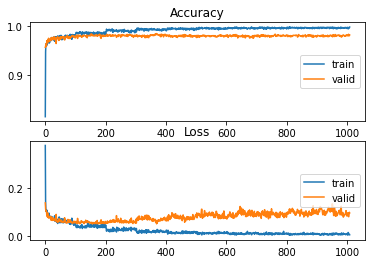

In [ ]:
# plot accuracy, loss graph for train, valid datasets

plot_graph(accloss_filename)